# IUCN Red List Data

Our main data source is the International Union For Conservation of Nature (IUCN). This is an international organization working on the field of nature conservation. They provide the most relevant and detaild data on threatened and extinct species.

In [1]:
import numpy as np 
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from countries import get_country_list, get_for_IUCN

## Getting the Data

We encountered several problems for utilizing the data provided by the IUCN.

### Dificulties

First, summery statistics. The provided data is often times in a format that is not machine readable (PDFs) or when machine readable files (CSVs) are available the data is not provided in sufficent detail per country. 
Second, spatial data. This type of data provides detaild information per group of species. The data is provided as polygons but as our goal is to compare different characteristics of countries we would have to map the polygons to countries which is not a trivial task as the IUCNs process to define which species is resident in which country is very sophisticated and not easy to reproduce.
Third, there is no "historical" data on threatened species. Only some PDFs document the changes in status per species and year but the IUCN specifically states that "This table (Table 7) should not be used to calculate a Red List Index (RLI); for this it is necessary to analyse the underlying Red List data to identify genuine status changes between specific years for specific taxonomic groups."

### Solution

The approach we therefore took was to scrape the needed data from the IUCN webpage using the advanced search at: https://www.iucnredlist.org/search

We approached getting the data by using **selenium** and **beautifulsoup4** as they let us navigate the IUCN Webpage and extract the species on a per country level.

### ToDo: 
- explain scraping process

## Load Raw Data

In this step we load the raw scraped data as provided on the IUCN webpage.

### ToDo:
- describe and comment

In [2]:
def load_IUCN_data():
    all_countries = []
    DATA_PATH = Path('./data/IUCN/scraped/')
    file_paths = DATA_PATH.glob('*.csv')

    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df['country'] = file_path.stem
        all_countries.append(df)
    return pd.concat(all_countries, ignore_index=True)
IUCN_raw_data = load_IUCN_data()

In [3]:
IUCN_raw_data.shape

(136624, 7)

In [4]:
IUCN_raw_data.head()

,kingdom_class,common_name,scientific_name,trend,region,threat_level,country
0,animalia — gastropoda,Lapidary Snail,Helicigona lapicida,Stable,"Global, Europe",Least Concern,Latvia
1,animalia — gastropoda,Moss Chrysalis Snail,Pupilla muscorum,Decreasing,"Global, Europe",Least Concern,Latvia
2,animalia — mammalia,Nathusius' Pipistrelle,Pipistrellus nathusii,Unknown,Global,Least Concern,Latvia
3,animalia — insecta,Ashton's Cuckoo Bumblebee,Bombus bohemicus,Decreasing,Global,Data Deficient,Latvia
4,animalia — insecta,NaN,Cucujus cinnaberinus,Increasing,"Global, Europe",Near Threatened,Latvia


## Problems in dataset

In [5]:
IUCN_raw_data.isna().sum()

kingdom_class          0
common_name        43403
scientific_name        0
trend               2986
region                 0
threat_level           0
country                0
dtype: int64

In [6]:
# kingdom the same as we only read animals
# scientific class names not human readable and include sea animals
IUCN_raw_data['kingdom_class'].unique()

array(['animalia — gastropoda', 'animalia — mammalia',
       'animalia — insecta', 'animalia — amphibia', 'animalia — aves',
       'animalia — actinopterygii', 'animalia — reptilia',
       'animalia — bivalvia', 'animalia — chondrichthyes',
       'animalia — malacostraca', 'animalia — holothuroidea',
       'animalia — cephalopoda', 'animalia — cephalaspidomorphi',
       'animalia — arachnida', 'animalia — clitellata',
       'animalia — myxini', 'animalia — anthozoa',
       'animalia — maxillopoda', 'animalia — hydrozoa',
       'animalia — merostomata', 'animalia — echinoidea',
       'animalia — branchiopoda', 'animalia — enopla',
       'animalia — onychophora', 'animalia — asteroidea',
       'animalia — ostracoda', 'animalia — monoplacophora',
       'animalia — diplopoda', 'animalia — entognatha',
       'animalia — sarcopterygii', 'animalia — turbellaria',
       'animalia — polychaeta'], dtype=object)

In [7]:
# not sure how to use region
IUCN_raw_data['region'].unique()

array(['Global, Europe', 'Global', 'Global, Europe, Mediterranean',
       'Global, Mediterranean', 'Global, Arabian Sea',
       'Global, Caribbean', 'Global, Caribbean, Gulf of Mexico',
       'Global, Gulf of Mexico', 'Global, Persian Gulf',
       'Global, Northern Africa, Pan-Africa', 'Global, Pan-Africa',
       'Global, Pan-Africa, S. Africa FW',
       'Global, Eastern Africa, Pan-Africa'], dtype=object)

In [8]:
# missing data on web search "[missing "en.shared.categories.cd" translation]"
IUCN_raw_data.threat_level.unique()

array(['Least Concern', 'Data Deficient', 'Near Threatened', 'Vulnerable',
       'Endangered', 'Critically Endangered', 'Extinct',
       '[missing "en.shared.categories.cd" translation]',
       'Extinct in the Wild'], dtype=object)

## Preparing the data

For the threat_level some datapoints are missing. We checked the species directly on the webpage.
There is no value for is and so and we use 'Data Deficient' for these.

### Translate classes of animals
From Wikipedia as nothing found on IUCN

- mammalia: Mammals
- actinopterygii: Ray-finned fishes
- insecta: Insects
- amphibia: Amphibians
- aves: Birds
- bivalvia: clams, oysters, cockles, mussels, scallops
- gastropoda: Snails and Slugs (could also be located in the sea)
- cephalaspidomorphi: jawless fishes
- clitellata: Worms
- reptilia: Reptiles
- chondrichthyes: cartilaginous fishes
- malacostraca: crustaceans
- hydrozoa: individually very small, predatory animals, most living in salt water
- turbellaria: flatworms

call class -> group as it could lead to problems with name class in python

### Todo
- describe and comment

In [9]:
def clean_data(data, filter_terrestrial=True):
    # remove column common name and region
    data = data.drop(columns=['common_name', 'region'])

    # categorize missing scraped data for trend to existing Data Deficient category
    data.threat_level.replace({
        '[missing "en.shared.categories.cd" translation]': 'Data Deficient'},
        inplace=True)

    # fill nan vlaues in trend with existing Unknown category
    data.trend.fillna('Unknown', inplace=True)

    # extract only class as kingdom is always animalia
    data['kingdom_class'] = data.apply(lambda row: row['kingdom_class'].split()[-1], axis=1)
    data = data.rename(columns={'kingdom_class': 'group'})

    # only select none sea animals
    none_sea_animals = ['mammalia', 'insecta', 'amphibia', 'aves', 'clitellata', 'reptilia']
    # todo: uncomment
    # data = data[data.group.isin(none_sea_animals)]

    # rename classes 
    data.group.replace({
        'mammalia': 'Mammals',
        'insecta': 'Insects',
        'amphibia': 'Amphibians',
        'aves': 'Birds',
        'clitellata': 'Worms',
        'reptilia': 'Reptiles',
        },
        inplace=True)

    # rename threat levels 
    data.threat_level.replace({
        'Extinct': 'EX',
        'Extinct in the Wild': 'EW',
        'Critically Endangered': 'CR',
        'Endangered': 'EN',
        'Vulnerable': 'VU',
        'Near Threatened': 'NT',
        'Least Concern': 'LC',
        'Data Deficient': 'DD',
        },
        inplace=True)

    return data
IUCN_cleaned_data = clean_data(IUCN_raw_data)

In [10]:
IUCN_cleaned_data.shape

(136624, 5)

In [11]:
IUCN_cleaned_data.head()

,group,scientific_name,trend,threat_level,country
0,gastropoda,Helicigona lapicida,Stable,LC,Latvia
1,gastropoda,Pupilla muscorum,Decreasing,LC,Latvia
2,Mammals,Pipistrellus nathusii,Unknown,LC,Latvia
3,Insects,Bombus bohemicus,Decreasing,DD,Latvia
4,Insects,Cucujus cinnaberinus,Increasing,NT,Latvia


## Check if scraped data is complete

For this we use Table 6a of the IUCN Summary Statistics

IUCN Red List Categories: EX - Extinct, EW - Extinct in the Wild, CR - Critically Endangered (includes CR(PE) and CR(PEW)), EN - Endangered, VU - Vulnerable, LR/cd - Lower Risk/conservation dependent, NT - Near Threatened (includes LR/nt - Lower Risk/near threatened), DD - Data Deficient, LC - Least Concern (includes LR/lc - Lower Risk/least concern).

CR(PE) & CR(PEW): The tags 'Possibly Extinct' and 'Possibly Extinct in the Wild' have been developed to identify CR species that are likely already extinct (or extinct in the wild), but require more investigation to confirm this. NOTE that these are not IUCN Red List Categories; they are tags that can be attached to the CR category to highlight those taxa that are possibly extinct. They are included in the above table to indicate a plausible upper estimate for number of recently extinct species on The IUCN Red List.

In [12]:
IUCN_cleaned_all = clean_data(IUCN_raw_data, filter_terrestrial=False)
grouped = IUCN_cleaned_all.groupby(['country', 'threat_level'])['scientific_name'].count().reset_index(name='count')
species_tl = grouped.pivot(index='country', columns='threat_level', values='count')
species_tl = species_tl.fillna(0.0)
species_tl['Total'] = species_tl.sum(axis=1)
species_tl.shape

(65, 9)

In [13]:
def load_table6a(threat_levels, country_rename_mapper, country_list):
    # load data
    DATA_PATH = Path('./data/IUCN')
    data = pd.read_csv(DATA_PATH / 'Table 6a Animal species (kingdom Animalia) by country - show all.csv', thousands=',')
    # rename columns
    data = data.rename(columns={
        'Name': 'country',
        'NT or LR/nt': 'NT',
        'LC or LR/lc': 'LC',
    })
    # only select needed threat_levels
    data = data[['country'] + threat_levels]
    # rename countrys
    data.country.replace(country_rename_mapper, inplace=True)
    # only select needed countrys
    data = data[data.country.isin(country_list)] 
    data = data.set_index('country')

    return data

threat_levels = list(species_tl.columns)
country_dict = get_for_IUCN()
country_rename_mapper = {d['country_iucn']: d['country_name'] for d in country_dict}
country_list = get_country_list()
table6a = load_table6a(threat_levels, country_rename_mapper, country_list)
assert len(country_list) == table6a.shape[0]

In [14]:
test = table6a.copy().reset_index()
test['Total_calc'] = test.drop(columns=['Total']).sum(axis=1)

species_tl_total = species_tl[['Total']].rename(columns={'Total': 'Total_scraped'})
species_tl_total = species_tl_total.reset_index()
test = test.merge(species_tl_total, how='left', on='country')

test['diff_to_calc'] = test['Total'] - test['Total_calc']
test['diff_to_scraped'] = test['Total'] - test['Total_scraped']
test['diff_calc_scraped'] = test['Total_calc'] - test['Total_scraped']

In [15]:
test[test['diff_to_calc'] > 0]

,country,CR,DD,EN,EW,EX,LC,NT,VU,Total,Total_calc,Total_scraped,diff_to_calc,diff_to_scraped,diff_calc_scraped
1,Japan,46,508,149,1,14,3372,267,256,4616,4613,4615.0,3,1.0,-2.0
35,Mexico,202,585,343,9,21,4930,217,362,6670,6669,6669.0,1,1.0,0.0
37,United States,224,609,298,4,237,5719,336,566,7998,7993,7994.0,5,4.0,-1.0
42,Australia,138,661,255,0,42,5868,442,613,8022,8019,8020.0,3,2.0,-1.0
43,New Caledonia,41,182,56,0,5,2187,163,159,2796,2793,2795.0,3,1.0,-2.0
45,Northern Mariana Islands,9,70,24,0,2,1293,91,72,1564,1561,1562.0,3,2.0,-1.0
47,Brazil,105,700,144,2,11,4768,230,287,6256,6247,6249.0,9,7.0,-2.0
49,Colombia,126,586,227,0,1,5283,259,361,6845,6843,6840.0,2,5.0,3.0
50,Peru,58,474,155,0,1,3891,204,209,4994,4992,4991.0,2,3.0,1.0
51,India,94,868,230,0,0,4332,331,398,6255,6253,6253.0,2,2.0,0.0


In [16]:
test[test['diff_to_scraped'] > 0]

,country,CR,DD,EN,EW,EX,LC,NT,VU,Total,Total_calc,Total_scraped,diff_to_calc,diff_to_scraped,diff_calc_scraped
1,Japan,46,508,149,1,14,3372,267,256,4616,4613,4615.0,3,1.0,-2.0
14,Greenland,2,20,5,0,1,217,8,20,273,273,272.0,0,1.0,1.0
34,Costa Rica,35,235,82,0,4,3392,107,154,4009,4009,4008.0,0,1.0,1.0
35,Mexico,202,585,343,9,21,4930,217,362,6670,6669,6669.0,1,1.0,0.0
36,Canada,18,87,32,0,9,1902,64,84,2196,2196,2195.0,0,1.0,1.0
37,United States,224,609,298,4,237,5719,336,566,7998,7993,7994.0,5,4.0,-1.0
40,Russia,28,233,49,1,3,1735,118,111,2278,2278,2277.0,0,1.0,1.0
42,Australia,138,661,255,0,42,5868,442,613,8022,8019,8020.0,3,2.0,-1.0
43,New Caledonia,41,182,56,0,5,2187,163,159,2796,2793,2795.0,3,1.0,-2.0
44,New Zealand,45,210,77,0,23,1066,66,109,1596,1596,1594.0,0,2.0,2.0


In [17]:
test[test['diff_calc_scraped'] > 0]

,country,CR,DD,EN,EW,EX,LC,NT,VU,Total,Total_calc,Total_scraped,diff_to_calc,diff_to_scraped,diff_calc_scraped
14,Greenland,2,20,5,0,1,217,8,20,273,273,272.0,0,1.0,1.0
34,Costa Rica,35,235,82,0,4,3392,107,154,4009,4009,4008.0,0,1.0,1.0
36,Canada,18,87,32,0,9,1902,64,84,2196,2196,2195.0,0,1.0,1.0
40,Russia,28,233,49,1,3,1735,118,111,2278,2278,2277.0,0,1.0,1.0
44,New Zealand,45,210,77,0,23,1066,66,109,1596,1596,1594.0,0,2.0,2.0
46,Argentina,41,178,69,3,3,2211,127,118,2750,2750,2748.0,0,2.0,2.0
48,Chile,25,201,62,0,1,1302,84,81,1756,1756,1754.0,0,2.0,2.0
49,Colombia,126,586,227,0,1,5283,259,361,6845,6843,6840.0,2,5.0,3.0
50,Peru,58,474,155,0,1,3891,204,209,4994,4992,4991.0,2,3.0,1.0
52,Indonesia,185,1392,323,0,3,6307,640,654,9508,9504,9502.0,4,6.0,2.0


In [18]:
# how can this be explaned ? do I need to calculate something differen for some categorys?
# how to explain this difference in scraped data and data in the table ? data on probaply newer than summary statistics

# Inspect species

In [19]:
# number of unique animal species in all countrys
species = IUCN_cleaned_data.drop(columns=['country']).drop_duplicates()
species.shape

(52327, 4)

<AxesSubplot:>

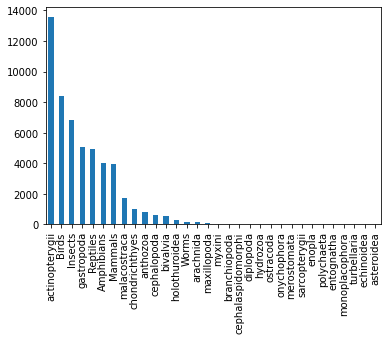

In [20]:
species.group.value_counts().plot(kind='bar')

<AxesSubplot:>

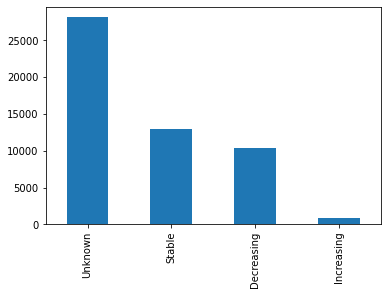

In [21]:
species.trend.value_counts().plot(kind='bar')

<AxesSubplot:>

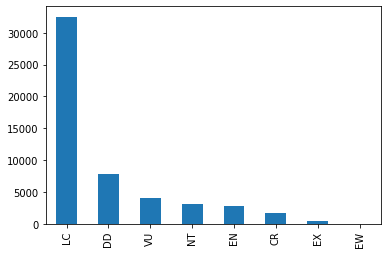

In [22]:
species.threat_level.value_counts().plot(kind='bar')

# Create data for species per trend per country

In [23]:
# transform data
grouped = IUCN_cleaned_data.groupby(['country', 'trend'])['scientific_name'].count().reset_index(name='count')
species_trend_country = grouped.pivot(index='country', columns='trend', values='count')
species_trend_country = species_trend_country.fillna(0.0)
species_trend_country['Total'] = species_trend_country.sum(axis=1)
species_trend_country.shape

(65, 5)

In [24]:
species_trend_country.head()

trend,Decreasing,Increasing,Stable,Unknown,Total
country,,,,,
Argentina,676,97,952,1023,2748
Armenia,199,71,169,129,568
Australia,1156,94,1855,4915,8020
Austria,316,87,342,361,1106
Azerbaijan,230,77,199,218,724


## Create data for species per threat level per country

In [25]:
# transform data
grouped = IUCN_cleaned_data.groupby(['country', 'threat_level'])['scientific_name'].count().reset_index(name='count')
species_tl_country = grouped.pivot(index='country', columns='threat_level', values='count')
species_tl_country = species_tl_country.fillna(0.0)
species_tl_country['Total'] = species_tl_country.sum(axis=1)
species_tl_country.shape

(65, 9)

In [26]:
species_tl_country.head()

threat_level,CR,DD,EN,EW,EX,LC,NT,VU,Total
country,,,,,,,,,
Argentina,40.0,178.0,69.0,3.0,3.0,2210.0,127.0,118.0,2748.0
Armenia,7.0,18.0,8.0,0.0,0.0,471.0,38.0,26.0,568.0
Australia,137.0,664.0,255.0,0.0,42.0,5867.0,442.0,613.0,8020.0
Austria,24.0,66.0,29.0,0.0,3.0,851.0,81.0,52.0,1106.0
Azerbaijan,13.0,45.0,10.0,1.0,0.0,583.0,41.0,31.0,724.0


This DataFrames include the same data as the "Table 6a" and makes not that much sense to use but we could use this to check if the data on the webpage is reasonable or if ther has gone something wrong when web scraping.

## Create data for species per class per country

In [27]:
# transform data
grouped = IUCN_cleaned_data.groupby(['country', 'group'])['scientific_name'].count().reset_index(name='count')
species_group_country = grouped.pivot(index='country', columns='group', values='count')
species_group_country = species_group_country.fillna(0.0)
species_group_country['Total'] = species_group_country.sum(axis=1)
species_group_country.shape

(65, 33)

In [28]:
species_group_country.head()

group,Amphibians,Birds,Insects,Mammals,Reptiles,Worms,actinopterygii,anthozoa,arachnida,asteroidea,...,maxillopoda,merostomata,monoplacophora,myxini,onychophora,ostracoda,polychaeta,sarcopterygii,turbellaria,Total
country,,,,,,,,,,,,,,,,,,,,,
Argentina,165.0,1001.0,242.0,379.0,376.0,0.0,393.0,0.0,3.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2748.0
Armenia,8.0,297.0,73.0,92.0,43.0,0.0,31.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,568.0
Australia,223.0,726.0,563.0,354.0,992.0,3.0,3140.0,587.0,6.0,0.0,...,17.0,0.0,0.0,5.0,1.0,4.0,0.0,1.0,1.0,8020.0
Austria,19.0,305.0,323.0,88.0,13.0,1.0,69.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1106.0
Azerbaijan,11.0,348.0,73.0,104.0,50.0,0.0,94.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,724.0


This DataFrames include the same data as the "Table 5" and makes not that much sense to use but we could use this to check if the data on the webpage is reasonable or if ther has gone something wrong when web scraping.